In [ ]:
# script to replace the base mechanism with new reactions (every reaction calculated) and species (all species calculated for now)

In [1]:
import os
import datetime
import subprocess
import numpy as np

import rmgpy.chemkin
import rmgpy.data.kinetics
# import cantera as ct


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_kinetics(rxns, labels=None):
    """Function for plotting reaction kinetics
    Takes in a list of RMG reactions (rmgpy.reaction.Reaction) or a single reaction
    """
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('ln(k)')

    if type(rxns) != list:
        rxns = [rxns]
    
    T = np.linspace(300, 3000, 1001)
    for rxn in rxns:
        k = np.zeros(len(T))
        for i in range(0, len(T)):
            k[i] = rxn.get_rate_coefficient(T[i], 101325)
        plt.plot(1000.0 / T, np.log(k))

    if labels:
        plt.legend(labels)
    plt.show()

In [3]:
def plot_thermos(thermos, labels=None):
    %matplotlib inline
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(12, 3)
    fig.tight_layout()
    ax[0].set_xlabel('Temperature (K)')
    ax[0].set_ylabel('H (kJ / mol)')
    ax[0].set_title('Enthalpy vs. Temperature')
    ax[1].set_xlabel('Temperature (K)')
    ax[1].set_ylabel('S (kJ / mol K)')
    ax[1].set_title('Entropy vs. Temperature')
    ax[2].set_xlabel('Temperature (K)')
    ax[2].set_ylabel('Cp (kJ / mol K)')
    ax[2].set_title('Heat Capacity vs. Temperature')
    T = np.linspace(300, 3000, 1001)
    for thermo in thermos:
        H = np.zeros(len(T))
        S = np.zeros(len(T))
        Cp = np.zeros(len(T))
        for i in range(0, len(T)):
            H[i] = thermo.get_enthalpy(T[i]) / 1000.0
            S[i] = thermo.get_entropy(T[i]) / 1000.0
            Cp[i] = thermo.get_heat_capacity(T[i]) / 1000.0
        ax[0].plot(T, H)
        ax[1].plot(T, S)
        ax[2].plot(T, Cp)
    ax[0].legend(labels)
    ax[1].legend(labels)
    ax[2].legend(labels)
    plt.subplots_adjust(wspace=0.25)

In [4]:
# Load the base model
basedir = '/work/westgroup/harris.se/autoscience/autoscience/butane/rmg_model'
new_model_dir = '/work/westgroup/harris.se/autoscience/autoscience/butane/improved_models'
base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)



In [5]:
# Load the new kinetics library
DFT_DIR = "/work/westgroup/harris.se/autoscience/autoscience/butane/dft/"
kinetics_lib = os.path.join(DFT_DIR, 'kinetics', 'kinetics')
ark_kinetics_database = rmgpy.data.kinetics.KineticsDatabase()
ark_kinetics_database.load_libraries(kinetics_lib)

In [ ]:
# stitch each of the library reactions into the mechanism (depends on library index matching indexing in chemkin file)
for key in ark_kinetics_database.libraries[''].entries.keys():
    entry = ark_kinetics_database.libraries[''].entries[key]
    index = entry.index
#     print(index, '\t', entry.label, '\t', reaction_list[index])
    
    if entry.item.is_isomorphic(reaction_list[entry.index]):
        rmg_rxn_index = entry.index
    else:
        print('Library reaction index does not match chemkin index')
        for i, reaction in enumerate(reaction_list):
            if entry.item.is_isomorphic(reaction):
                rmg_rxn_index = i
                break
        else:
            raise ValueError ('could not match reaction index')
                
    print(f'Changing reaction {rmg_rxn_index}')
    if rmg_rxn_index == 288:
        reaction_list[rmg_rxn_index].kinetics = entry.data
#     break
    # compare the kinetics
    plot_kinetics([reaction_list[rmg_rxn_index], entry.data], ['RMG', 'DFT'])
    

In [6]:
# Load the new thermo library
thermo_lib = os.path.join(DFT_DIR, 'thermo', 'thermo')
ark_thermo_database = rmgpy.data.thermo.ThermoDatabase()
ark_thermo_database.load_libraries(thermo_lib)

In [ ]:
ark_thermo_database.libraries

79
Changing estimated thermo 79: C[C]C(689)
83
Changing estimated thermo 83: C[C]CC-2(776)
85
Changing estimated thermo 85: CC(CCOO)OO(787)
88
Changing estimated thermo 88: O=C1COC1(917)
96
Changing estimated thermo 96: C1OO1(4213)
101
Changing estimated thermo 101: [C]1CCC1(4880)
103
Changing estimated thermo 103: OCCC1CO1(5151)


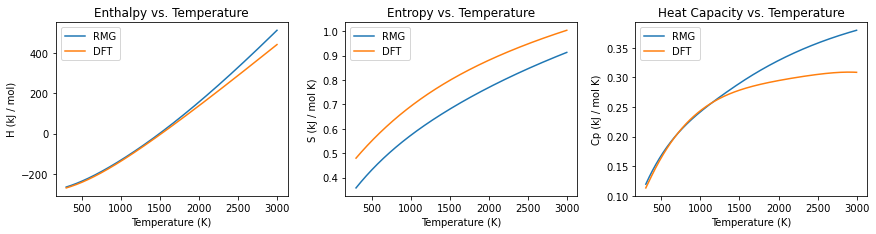

In [7]:
# stitch each of the library thermos into the mechanism

plot_index = [79]

for key in ark_thermo_database.libraries['harris_butane'].entries.keys():
    entry = ark_thermo_database.libraries['harris_butane'].entries[key]
#     print(entry)

    for i, species in enumerate(species_list):
#         if entry.item.is_isomorphic(species.molecule[0]):
        if entry.item.smiles == species.smiles:
            rmg_species_index = i
            break
    else:
        raise ValueError (f'could not match species index {entry}')
    
    if 'library' not in species_list[rmg_species_index].thermo.comment.lower():
        print(rmg_species_index)
        plot_thermos([species_list[rmg_species_index], entry.data], ['RMG', 'DFT'])
        
        print(f'Changing estimated thermo {rmg_species_index}: {species_list[rmg_species_index]}')
        species_list[rmg_species_index].thermo = entry.data
    
#     if rmg_species_index in plot_index:
#         plot_thermos([species_list[rmg_species_index], entry.data], ['RMG', 'DFT'])

#     break
#     print(species_list[rmg_species_index])
#     print(f'Changing reaction {rmg_rxn_index}')
#     if rmg_rxn_index == 288:
#         reaction_list[rmg_rxn_index].kinetics = entry.data
# #     break
#     # compare the kinetics
#     plot_kinetics([reaction_list[rmg_rxn_index], entry.data], ['RMG', 'DFT'])
    

In [8]:
# save the resulting mechanism
timestamp_str = datetime.datetime.now().isoformat()[0:10]
chemkin_file = os.path.join(new_model_dir, f'chem_{timestamp_str}.inp')
rmgpy.chemkin.save_chemkin_file(chemkin_file, species_list, reaction_list, verbose=True, check_for_duplicates=True)
subprocess.run(['ck2cti', f'--input={chemkin_file}', f'--transport={transport}', f'--output={new_model_dir}/chem_{timestamp_str}.cti'])
# os.remove(chemkin_file)



Wrote CTI mechanism file to '/work/westgroup/harris.se/autoscience/autoscience/butane/improved_models/chem_2022-08-22.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.


CompletedProcess(args=['ck2cti', '--input=/work/westgroup/harris.se/autoscience/autoscience/butane/improved_models/chem_2022-08-22.inp', '--transport=/work/westgroup/harris.se/autoscience/autoscience/butane/rmg_model/tran.dat', '--output=/work/westgroup/harris.se/autoscience/autoscience/butane/improved_models/chem_2022-08-22.cti'], returncode=0)

In [ ]:
reaction_list[749].kinetics

In [ ]:
entry.data

In [ ]:
entry.item.is_isomorphic(reaction_list[749])

In [ ]:
dir(entry)

In [ ]:
ark_kinetics_database.libraries[''].entries